In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !rm -rf /content

In [3]:
!git clone https://github.com/interactivetech/centernet-tutorial/

Cloning into 'centernet-tutorial'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 125 (delta 73), reused 85 (delta 35), pack-reused 0
Receiving objects: 100% (125/125), 2.88 MiB | 11.34 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [4]:
import torch
import sys
sys.path.insert(0,'/content/centernet-tutorial/')
from data_gen import ShapeDataset
import matplotlib.pyplot as plt
from PIL import Image
from data import COCODetectionDataset, coco_detection_collate_fn, train_transform_norm, validation_transform_norm
from tqdm import tqdm
import numpy as np
from model import centernet
from loss import centerloss4
from train import train
from utils import pred2box_multiclass, filter_and_nms
import cv2

<h3> Table of Contents </h3>
<ul>
<li><a href="#Prelims">Prelims</a></li>
<li><a href="#Background">Background</a><ul>
<li><a href="#single-vs-two-stage">Single Stage vs Two Stage</a></li>
<li><a href="#Centernet">Centernet</a></li>
</ul>
<li><a href="#Preprocessing">Preprocessing</a></li>
<ul>
<li><a href="#Encode-Location-as-Gaussian-Keypoints">Encode Location as Gaussian Keypoints</a></li>
<li><a href="#Encode-Width-and-Height">Encode Width and Height</a></li>
</ul>
<li><a href="#Model Architecture">Model Architecture</a></li>
<ul>
<li><a href="#Backbone">Backbone</a></li>
<li><a href="#Class Head">Class Head</a></li>
<li><a href="#Regression Head">Regression Head</a></li>
<li><a href="#Initalization for Focal Loss">Initalization for Focal Loss</a></li>
</ul>
<li><a href="#Loss Function">Loss Function</a></li>
<ul>
<li><a href="#Focal Loss">Focal Loss</a></li>
<li><a href="#Regression Loss">Regression Loss</a></li>
</ul>
<li><a href="#Prepare-Training-Model">Prepare Training Model</a></li>
<li><a href="#Train-Model">Train Model</a></li>
<li><a href="#Evaluate-Loss-Curves">Evaluate Loss Curves</a></li>
<li><a href="#Evaluate-Model-Predictions">Evaluate Model Predictions</a></li>

</ul>


# Prelims

Generate Dataset

In [5]:
s = ShapeDataset(n_images = 8,n_circles=1,n_rectangles=1)
s.gen_dataset()

Num Circle: 1
Num Circle+Rect: 2
Num Anns: 3
[{'segmentation': [], 'area': 2500, 'iscrowd': 0, 'image_id': 1, 'bbox': [276, 44, 50, 50], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [287, 353, 32, 32], 'category_id': 1, 'id': 2}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}]
Num Circle: 1
Num Circle+Rect: 2
Num Anns: 5
[{'segmentation': [], 'area': 2500, 'iscrowd': 0, 'image_id': 1, 'bbox': [276, 44, 50, 50], 'category_id': 0, 'id': 1}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 1, 'bbox': [287, 353, 32, 32], 'category_id': 1, 'id': 2}, {'segmentation': [], 'area': 2916, 'iscrowd': 0, 'image_id': 2, 'bbox': [104, 238, 54, 54], 'category_id': 0, 'id': 3}, {'segmentation': [], 'area': 1024, 'iscrowd': 0, 'image_id': 2, 'bbox': [289, 283, 32, 32], 'category_id': 1, 'id': 4}]
[{'file_name': 'dummy_1.png', 'height': 512, 'width': 512, 'id': 1}, {'file_name': 'dummy_2.png', 'height': 512, 'width':

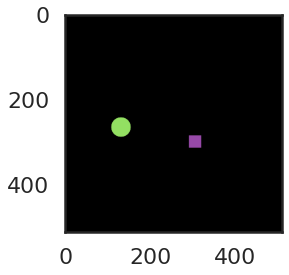

In [6]:
im = Image.open('dummy_2.png')
plt.imshow(im)

In [17]:
ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                transform=train_transform_norm,
                MODEL_SCALE=4)
val_ds = COCODetectionDataset(img_dir='/content/',
                ann_json='/content/coco_shapes.json',
                IMG_RESOLUTION=512,
                MODEL_SCALE=4,
                transform=validation_transform_norm)
BATCH_SIZE = 8
train_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)
val_loader = torch.utils.data.DataLoader(ds,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=0,
                                        pin_memory=True,
                                        collate_fn = coco_detection_collate_fn)


label_map: {0: 0, 1: 1}
label_map: {0: 0, 1: 1}


In [18]:
len(ds)

8

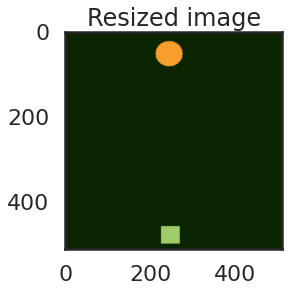

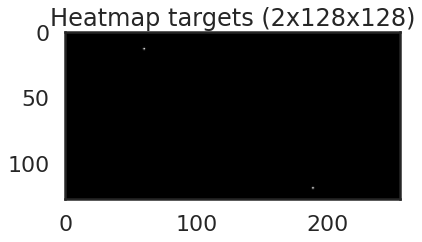

In [19]:
img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target, idx= ds[0]
mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
img_u = img.transpose(1,2,0)*std + mean# unnormalize
# img = img 
plt.imshow(img_u)
plt.title("Resized image")

plt.show()
c,h,w = hm.shape
nrows = 1
ncols = 2
hm_u = hm.reshape(nrows, ncols, h, w).swapaxes(1,2).reshape(h*nrows, w*ncols)
# hm_u = hm.transpose(1,2,0)
plt.imshow(hm_u,cmap='gray')
plt.title("Heatmap targets (2x128x128)")
plt.show()

# Background

## Two Stage vs Single Stage
<a id='single-vs-two-stage'></a>

Two Stage Model Architectures (Faster-RCNN, Cascade RCNN, etc) comprise of two stages:
 * First stage is feature extraction and region proposal network (RPN)
 * Second Stage is Region of Interest Pooling, and then regression from anchor priors

Single Stage Detectors (SSD, Retinanet, etc) do not use RPN or ROI layers, they directly regress bounding box locations and class prefictions from CNN features. Many Single Stage Detectors use Anchor Priors to make learning easier

Limitations of using Anchor Priors: Anchors are another hyperparameter you need to tune to your dataset, adding complexity and hurting generalization

## Centernet

Centernet is a Single Stage, Anchor Free Object Detection model.
* Directly regresses object size, location, and other properties in a single forward pass, fully convolutional manner
* Objects are represented as center keypoints, and object size is regressed
* Eliminates need for anchor priors, additional hyperparameters needed for two stage detectors, and reduces SOTA performance with simplicity

* Centernet regresses:
 * Center location (cx, cy)
 * Object width and height: (w,h)
 * Offset location: (ox, oy)
   * original bounding box (image 512x512) is located in pixel coordinate 309,309
   * if image resized to 256 -> resized location is 309/2 = 154.5
   * Integer truncation will be 154
   * Need to regress offset to attain original coordiante: 154*2 + 1

Note: In this colab, we simplify the problem by only regressing object size and center location

# Preprocessing

Here we describe how the bounding boxes are preprocessed for the model to learn to predict objects in an image.

* Encode Class Keypoints: We compute the center location of objects, and encode the location as a gaussian keypoint heatmap. Keypoint Heatmap are an KxFWxFH tensor, where the location are encoded in a reduced feature pixel space. 
* Example, one object is at location 256,256, with size 100, 100 (assume image resolution is 512x512)
  * Model outputs at a lower resolution (256x256), so the ground truth needs to be resized to align with the output resolution: 128,128 center location, width is 50, height is 50

* Encode object width and height regression: The author of the paper proposes regressing object size by regressing a Tensor of 2xFWxFH. The tensor is same spatial resolution as the keypoint tensor (FWxFH) but with the 3rd dimension being 2 to encode width and height (so tensor is 2xFWxFH). 

## Encode Class Keypoints

```python
def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap
```

## Encoding bounding boxes using draw_umich_gaussian

```python
centers = np.array([bboxes[:,0]+bboxes[:,2]//2,bboxes[:,1]+bboxes[:,3]//2,bboxes[:,2],bboxes[:,3]]).T
for ind,(c,l )in enumerate(zip(centers,classes)):
    h, w = c[3]/MODEL_SCALE, c[2]/MODEL_SCALE
    radius = gaussian_radius((math.ceil(h), math.ceil(w)))
    radius = max(0, int(radius))
    # print("radius:", radius)
    draw_umich_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
                            radius)
    # draw_msra_gaussian(hm[l], [int(c[0])//MODEL_SCALE,int(c[1])//MODEL_SCALE], 
    #                         radius)
    reg_mask[ind] = 1
    wh[ind] = c[2:]/input_size
    draw_dense_reg(reg,hm[l],c[:2]//MODEL_SCALE,wh[ind],radius)
    inds[ind] = (int(c[1])//MODEL_SCALE)*feature_scale + (int(c[0])//MODEL_SCALE)
```

## Encode Width and Height Regression

```python
def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)

  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value

  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]

  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]

  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap
```

# Model Architecture
Here we will be defining an architecture that differs from the original author, but learns the same way as the original architecture.

* Architecture:
 * Backbone: MobilnetV3 CNN or Resnet18 model
 * Resolution of feature is 512x7x7
 * Three Layers that each comprise of:
   * Double Convolutional Layers
   * Upsampling Layer to increase resolution
 * After the convolution layers, the features will be size 256x256x256
 * Final Output Layers:
   * outc: outputs keypoint center location: Kx256X256
   * outr: outputs object sizes: 2x256x256


## Backbone

```python
if model_name == 'mv3':
            basemodel = torchvision.models.mobilenet_v3_small(pretrained=True)
            num_ch = 576
elif model_name == 'resnet18':
            basemodel = torchvision.models.resnet18(pretrained=True)
            num_ch = 512
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
# set basemodel
self.base_model = basemodel
# Neck
self.up1 = up(num_ch, 512,bilinear=True)
self.up2 = up(512, 256,bilinear=True)
self.up3 = up(256, 256,bilinear=True)
```

## Class Head and Regression Head

```python

# output classification
self.outc = nn.Conv2d(256, n_classes, 1)

self.outr = nn.Conv2d(256, 2, 1)
```

## Initalization of conv layers in Neck for Focal Loss

```python
'''
Author of focal loss:  all new conv layers except the 
final layer, subnets are initalized  with bias b=0 and
a Gaussian weight filled with sigma=0.01

Weight init improves training stability for both the 
cross entropy and focal loss in the case of heavy class
imbalance
'''
for m in self.conv.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight,std=0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias,0)
```

## Initalization of Layers in Head for Focal Loss

```python
'''
Author: the final conv later set the bias
initalization to log((1-pi)/pi)
pi specifies that at the start of training,
every anchor should be labeled as foreground
with confidence of about pi. pi is a variable that is 0.01

This initalization prevents a large number of background 
anchors from generating a large destabalizing loss value in the
in the first iteration of training
'''
self.outc.bias.data.fill_(-2.19)
# output residue
self.outr.bias.data.fill_(-2.19)
def forward(self, x):
batch_size = x.shape[0]
x = self.base_model(x) 

x = self.up1(x)
x = self.up2(x)
x = self.up3(x)
outc = self.outc(x)
outr = self.outr(x)
return outc, outr
```

In [20]:
model = centernet(ds.num_classes,model_name='mv3')

# Loss Function

# Focal Loss
$$
L_k = \frac{-1}{N} \sum_{xyc}
\begin{cases}
(1 - \hat{Y}_{xyc})^{\alpha} 
        \log(\hat{Y}_{xyc})  & \text{ if } Y_{xyc}=1 \\
\begin{array}{c}
        (1-Y_{xyc})^{\beta} 
        (\hat{Y}_{xyc})^{\alpha}\\
        \log(1-\hat{Y}_{xyc})
        \end{array} & \text{ otherwise }
\end{cases}
$$

```python 
def focal_loss(pred, gt):
  ''' Modified focal loss.
    Arguments:
      pred (batch x h x w)
      gt (batch  x h x w)
  '''
  pos_inds = gt.eq(1).float()
  neg_inds = gt.lt(1).float()
  neg_weights = torch.pow(1 - gt, 4)

  loss = 0
  prob_pred = F.sigmoid(pred)
  pos_loss = F.logsigmoid(pred) * torch.pow(1 - prob_pred, 2) * pos_inds
  neg_loss = F.logsigmoid(1 - pred) * torch.pow(prob_pred, 2) * neg_inds *  neg_weights 

  num_pos  = pos_inds.float().sum()
  pos_loss = pos_loss.sum()
  neg_loss = neg_loss.sum()

  if num_pos == 0:
    loss = loss - neg_loss
  else:
    loss =  loss - (pos_loss + neg_loss) / (num_pos+1e-4)
  return loss
  ```

# Regression Loss
$$
L_{size} = \frac{1}{N}\sum_{k=1}^{N} \left|\hat S_{p_k} - s_k\right|.
$$

```python
def reg_loss(regr, gt_regr, mask):
  ''' L1 regression loss
    Arguments:
      regr (batch x max_objects x dim)
      gt_regr (batch x max_objects x dim)
      mask (batch x max_objects)
  '''
  num = mask.float().sum()
  mask = mask.unsqueeze(2).expand_as(gt_regr).float()

  regr = regr * mask
  gt_regr = gt_regr * mask

  regr_loss = nn.functional.l1_loss(regr, gt_regr, size_average=False)
  regr_loss = regr_loss / (num + 1e-4)
  return regr_loss
  ````

# Prepare and Train Training Model

In [35]:
LR = 1e-3
# LR = 2.5e-4*BATCH_SIZE
model_mv3, losses, mask_losses, regr_losses, min_confidences, median_confidences, max_confidences = train('mv3',
                                                                                                          ds.num_classes,
                                                                                                          learn_rate=LR,
                                                                                                          epochs=300,
                                                                                                          train_loader=train_loader,
                                                                                                          val_loader=val_loader)

else


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback 

cuda:0


100%|██████████| 300/300 [04:24<00:00,  1.13it/s]


In [23]:
len(losses)

100

In [36]:
# LR = 2.5e-4*2
model_resnet18, losses_resnet18, mask_losses_resnet18, regr_losses_resnet18, min_confidences_r, median_confidences_r, max_confidences_r = train('resnet18',
                                                                                    ds.num_classes,
                                                                                    learn_rate=1e-3,
                                                                                    epochs= 300,
                                                                                    train_loader=train_loader,
                                                                                    val_loader=val_loader)


else
cuda:0


100%|██████████| 300/300 [04:55<00:00,  1.02it/s]


# Visualize Loss Curves

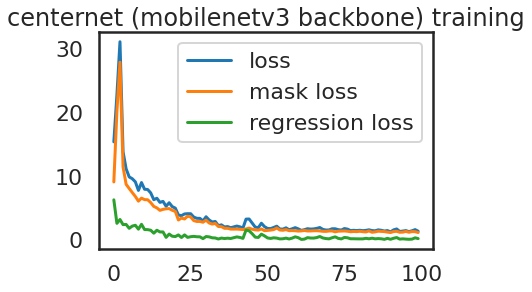

In [26]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses)),mask_losses)
plt.plot(range(len(losses)),regr_losses)
plt.title("centernet (mobilenetv3 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

## Visualize Confidence Scores over training

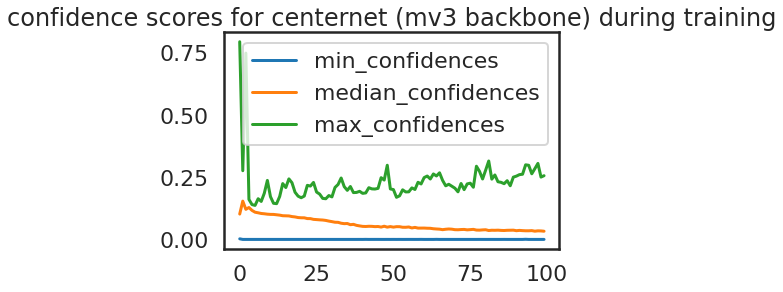

In [27]:
plt.plot(range(len(min_confidences)),min_confidences )
plt.plot(range(len(median_confidences)),median_confidences)
plt.plot(range(len(max_confidences)),max_confidences)
plt.title("confidence scores for centernet (mv3 backbone) during training")
plt.legend(['min_confidences','median_confidences','max_confidences'])
plt.show()

## Visualize Training Loss for Resnet18

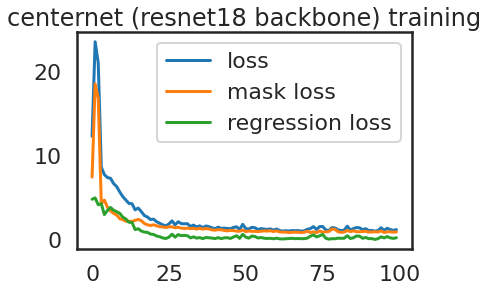

In [28]:
plt.plot(range(len(losses_resnet18)),losses_resnet18 )
plt.plot(range(len(losses_resnet18)),mask_losses_resnet18)
plt.plot(range(len(losses_resnet18)),regr_losses_resnet18)
plt.title("centernet (resnet18 backbone) training")
plt.legend(['loss','mask loss','regression loss'])
plt.show()

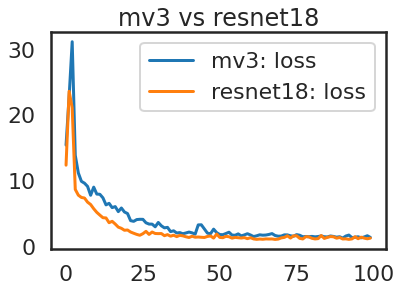

In [29]:
plt.plot(range(len(losses)),losses )
plt.plot(range(len(losses_resnet18)),losses_resnet18)
plt.title("mv3 vs resnet18")
plt.legend(['mv3: loss','resnet18: loss'])
plt.show()

# Visualize Predictions

In [ ]:
# model_mv3(torch.rand(1,3,512,512))

In [33]:
model_mv3.eval()
model_mv3.cpu()
for img, hm, reg, wh,reg_mask,inds, in_size, out_size, intermediate_size, scale, boxes_aug, target, idx in val_loader:
        break

pred_hm, pred_regs = model_mv3(img)# (4,1,128,128), (4,2,128,128)
pred_hm = torch.sigmoid(pred_hm)
# bboxes,scores,classes = pred2box_multiclass(pred_hm[0].cpu().data.numpy(),
#                                                         pred_regs[0].cpu().detach().numpy(),128,1,thresh=0.0)
bboxes,scores,classes = pred2box_multiclass(pred_hm[0].data.numpy(),pred_regs[0].data.numpy(),128,1,thresh=0.0)
bboxes,scores,classes =  filter_and_nms(bboxes,scores,classes,nms_threshold=0.45,n_top_scores=20)
print(bboxes)

[[128. 103. 128. 103.]
 [128. 102. 128. 102.]
 [125. 108. 125. 108.]
 [124. 109. 124. 109.]
 [123. 110. 123. 110.]
 [127. 107. 127. 107.]
 [121. 111. 121. 111.]
 [122. 110. 122. 110.]
 [123. 108. 123. 108.]
 [128. 106. 128. 106.]
 [128. 105. 128. 105.]
 [124. 107. 124. 107.]
 [121. 112. 121. 112.]
 [128. 104. 128. 104.]
 [125. 106. 125. 106.]
 [119. 112. 119. 112.]
 [128. 108. 128. 108.]
 [127. 109. 127. 109.]
 [128. 107. 128. 107.]
 [128. 109. 128. 109.]]


In [ ]:
hm.shape

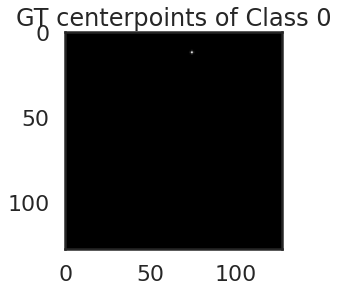

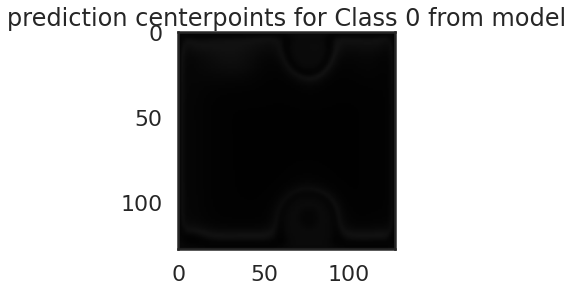

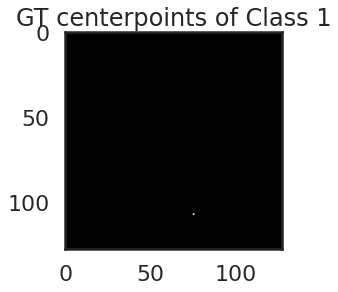

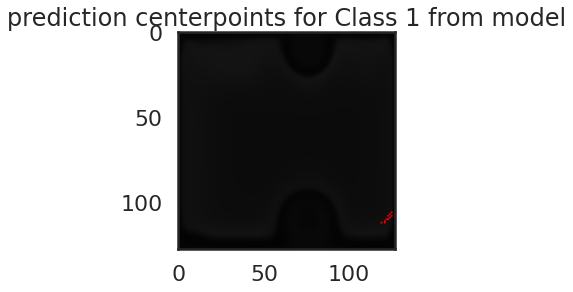

In [34]:
for i in range(hm.shape[1]):
    hm_gt = hm[0].data.numpy()[i]
    hm_pred = pred_hm[0].data.numpy()[i]
    hm_pred = np.dstack([hm_pred*255]*3).astype(np.uint8)
    for b,c in zip(bboxes,classes):
        if c == i:
            x,y,x2,y2 = [int(k) for k in b]
            # print(x,y)
            cv2.rectangle(hm_pred,(x,y),(x2,y2),(255,0,0),1)
        
    plt.imshow(hm_gt,cmap='gray')
    plt.title("GT centerpoints of Class {}".format(i))
    plt.show()
    plt.imshow(hm_pred)
    plt.title("prediction centerpoints for Class {} from model".format(i))
    plt.show()
